# Project 3 - Black-Box Policy Optimization

### Install necessary libraries and import packages


In [1]:
!wget  -q https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw3/project3.zip
!unzip -q project3.zip


In [4]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame
!pip3 install box2d-py


# Environment
import gym # OpenAI gym 
import frogger_env
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from random import sample

from collections import deque
import math

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os 


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpa

### Some useful functions

In [5]:
#Let's define a simple helper function for visualization of episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [6]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

  

# Q1. CEM

Implement below the cross-entropy method to solve the reacher-v0 environment and enable the agent to learn to navigate to a fixed goal position on a static highway map. Please, refer to the project descriprtion and lecture 13 for more details. 

Let's first test things out!

In [12]:
display = Display(visible=0, size=(600, 400))
display.start()

env = gym.make("reacher-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 2
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>



The observation that the agent receives is its position, the goal position, and a unit vector that points from the agent's position to the goal.

The action space consists of four actions 0: move up, 1: move down, 2: move right 3: move left

In [6]:
print('observation space:', env.observation_space.shape[0])
print('action space:', env.action_space.n)


observation space: 6
action space: 4


## Implement a policy network that the agent can use to select actions. 
Instead of training the parameters of the network, you will directly set them based on your CEM optimization. 

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################## Your code ####################################
class Agent(nn.Module): 
    def __init__(self, env, h_size=48):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.n
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)

    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self):
        """
        Returns the number of the NN parameters (weights, biases)
        """
        # print(self.s_size, self.fc1_units, self.fc2_units, self.a_size)
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.cpu().data
    
    def greedy_action(self, state):
 
        with torch.no_grad():
            q_values = self.forward(state).detach().numpy().squeeze()
        action = np.argmax(q_values)
        return action

    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        done = False
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            
            action = self.greedy_action(state)
            state, reward, done, _ = self.env.step(action)
            
            episode_return += reward * math.pow(gamma, t)
            if reward == 1:
                print('Reached in this episode')
                
            if done:
                break
        return episode_return

env = gym.make("reacher-v0")
agent = Agent(env).to(device)

## Train a CEM agent 

In [57]:

def cem_train(n_iterations=400, max_t = 100, gamma=1, print_every=1, pop_size=100, elite_frac=0.1, sigma=1.0, seed=12):
    torch.manual_seed(seed)
    np.random.seed(seed)
    n_elite = int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())
    # print(best_weight.shape)
    for i_iteration in range(1, n_iterations+1):
        # print(sigma)
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        # elite_rewards = [weights_pop[i] for i in elite_idxs]
        # print(elite_weights)
        best_weight = np.array(elite_weights).mean(axis=0)
        # print(best_weight)
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        sigma = np.array(elite_weights).std(axis=0)


        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=1.42:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    torch.save(agent.state_dict(), 'checkpoint.pth')
    return scores

scores = cem_train()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 1	Average Score: -0.30
Episode 2	Average Score: -0.31
Episode 3	Average Score: -0.31
Episode 4	Average Score: -0.30
Episode 5	Average Score: -0.30
Episode 6	Average Score: -0.30
Episode 7	Average Score: -0.29
Episode 8	Average Score: -0.31
Episode 9	Average Score: -0.33
Episode 10	Average Score: -0.31
Episode 11	Average Score: -0.30
Episode 12	Average Score: -0.31
Episode 13	Average Score: -0.33
Episode 14	Average Score: -0.34
Episode 15	Average Score: -0.33
Episode 16	Average Score: -0.31
Episode 17	Average Score: -0.30
Episode 18	Average Score: -0.29
Episode 19	Average Score: -0.28
Episode 20	Average Score: -0.27
Episode 21	Average Score: -0.26
Episode 22	Average Score: -0.25
Episode 23	Average Score: -0.24
Episode 24	Average Score: -0.24
Episode 25	Average Score: -0.23
Episode 26	Average Score: -0.23
Episode 27	Average Score: -0.22
Episode 28	Average Score: -0.22
Episode 29	Average Score: -0.21
Episode 30	Average Score: -0.21
Episode 31	Average Score: -0.21
Episode 32	Averag

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'CEM Steps')

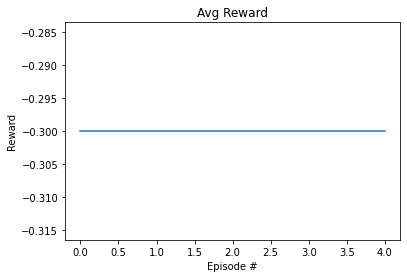

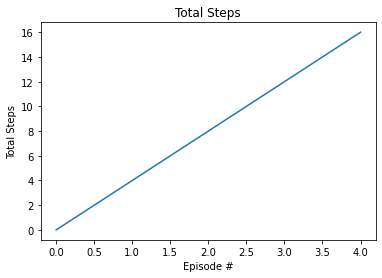

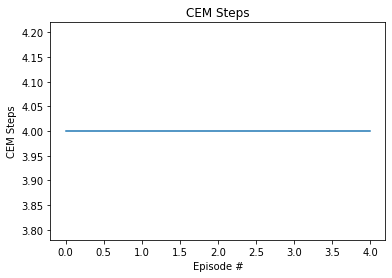

In [21]:
cem_score, cem_total_steps, cem_episode_steps = result.T

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(cem_score)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Avg Reward')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(cem_total_steps)
plt.ylabel('Total Steps')
plt.xlabel('Episode #')
ax2.set_title('Total Steps')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(cem_episode_steps)
plt.ylabel('CEM Steps')
plt.xlabel('Episode #')
ax3.set_title('CEM Steps')

In [ ]:
env = gym.make("reacher-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
agent.load_state_dict(torch.load('checkpoint.pth'))
state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    
    action = agent.greedy_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
env.close()
show_video('./video')

# Q2. ES

Implement below the non-distributed version of the evolution strategies method from  [[Salimans et al., 2017]](https://arxiv.org/pdf/1703.03864.pdf) to solve the LunarLanderContinuous-v2 environment and enable the agent to navigate to its landing pad. Please, refer to the project descriprtion and lecture 13 for more details. 


First, let's test the new environment out!

In [3]:
display = Display(visible=0, size=(900, 400))
display.start()

env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
i = 0
while not done:
    action = env.action_space.sample()
    print(i)
    obs, reward, done, info = env.step(action)
    i+=1
env.close()
show_video('./video')

NameError: ignored

The observation that the agent receives is its position, velocity, angular speed, and two 2 Boolean flags indicating whether the left and right leg of the agent, respectively, is in contact with the ground.

Two continuous actions are used to control the agent. The first one controls the main engine and the second one controls the left and right engines. *The expected range of each of the two actions is [-1, 1]. Please make sure that your policy network outputs values in that range*

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('solved_score', env.spec.reward_threshold)


## Implement a policy network that the agent can use to select actions. 
Instead of training the parameters of the network, you will directly set them based on your ES optimization. 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################## Your code ####################################
class ESAgent(nn.Module): 
    def __init__(self, env, h_size=256):
        super(ESAgent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)

    def forward(self, x):
        """
        Perform forward pass 
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.cpu().data
    
    def get_weights_dim(self):
        """
        Returns the number of the NN parameters (weights, biases)
        """
        return sum(p.numel() for p in self.parameters())
    
    def set_weights(self, weights):
        '''
        Function to copy a weight vector to the parameters (weights, biases) of the NN. 
        You can also set the weights outside of the class, e.g. using state_dict()

        Params
        ======
            weights (float): a flatten numpy array that contains the weight vector obtained through CEM
        '''
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self):
        """
        Returns the number of the NN parameters (weights, biases)
        """
        # print(self.s_size, self.fc1_units, self.fc2_units, self.a_size)
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size

    def greedy_action(self, state):
        
        with torch.no_grad():
            action = self.forward(state).detach().numpy().squeeze()
        
        if action[0] > 1.0:
            action[0] = 1.0
        elif action[0] < -1.0:
            action[0] = -1
        elif action[1] > 1.0:
            action[1] = 1.0
        elif action[1] < -1.0:
            action[1] = -1.0

        return action

    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        done = False
        episode_step = 0
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            
            action = self.greedy_action(state)
            state, reward, done, _ = self.env.step(action)
            
            episode_return += reward * math.pow(gamma, t)
            if reward == 1:
                print('Reached in this episode')
                
            if done:
                break
            episode_step += 1
        return episode_return, episode_step

env = gym.make("LunarLanderContinuous-v2")
es_agent = ESAgent(env).to(device)

## Train an ES agent


In [8]:

def es_train(n_iterations=1000, max_t = 1000, gamma=1, print_every=1, pop_size=50, sigma=0.5, seed=2, alpha = 1e-3):
    torch.manual_seed(seed)
    np.random.seed(seed)
    best_weight = sigma*np.random.randn(es_agent.get_weights_dim())
    scores_deque = deque(maxlen=100)
    scores = []
    i_iteration = 0
    total_steps = 0
    result = np.empty((n_iterations, 3))
    result[:] = np.nan 
    for i_iteration in range(n_iterations):
        epsilon = [np.random.randn(es_agent.get_weights_dim()) for i in range(pop_size)]
        weights_pop = [best_weight + (sigma*epsilon[i]) for i in range(pop_size)]
        rewards = np.array([es_agent.evaluate(weights, gamma, max_t)[0] for weights in weights_pop])
        total_reward_epsilon = np.zeros(es_agent.get_weights_dim())

        for i in range(pop_size):
            total_reward_epsilon += rewards[i]*epsilon[i]

        best_weight = best_weight + (alpha/(pop_size*sigma) * total_reward_epsilon)
        reward, episode_steps = es_agent.evaluate(best_weight, gamma=1.0)


        scores_deque.append(reward)
        scores.append(reward)
        i_iteration += 1
        total_steps += episode_steps
        result[i_iteration-1] = reward, total_steps, episode_steps
        print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>= env.spec.reward_threshold:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            break
        

        
    torch.save(es_agent.state_dict(), 'checkpoint_es.pth')
    return result 

result = es_train()






Episode 1	Average Score: -585.64


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'CEM Steps')

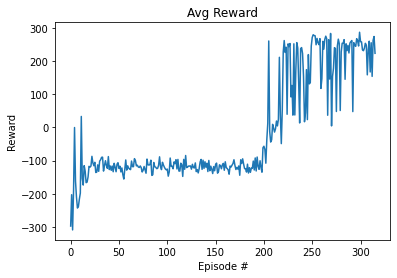

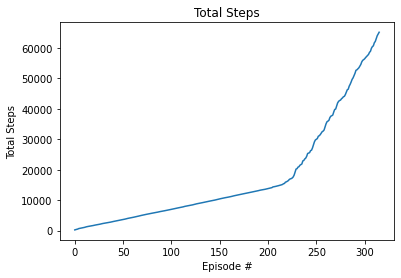

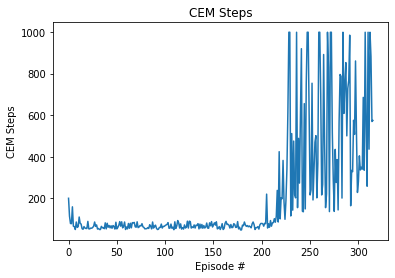

In [38]:

es_score, es_total_steps, es_episode_steps = result.T

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(es_score)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Avg Reward')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(es_total_steps)
plt.ylabel('Total Steps')
plt.xlabel('Episode #')
ax2.set_title('Total Steps')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(es_episode_steps)
plt.ylabel('CEM Steps')
plt.xlabel('Episode #')
ax3.set_title('CEM Steps')

In [11]:
display = Display(visible=0, size=(900, 400))
display.start()

env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)

done = False
es_agent.load_state_dict(torch.load('checkpoint_es.pth'))
state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    
    action = es_agent.greedy_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
env.close()
show_video('./video')

In [10]:
print(result)

NameError: ignored